# Aim to test various characcteristics of the problem

### Various functions and settings


In [1]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp, ndtr
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings
import seaborn as sns

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from utils import ESS_univariate

In [2]:
seed = 1234
m = 20     # number of latent variables
d = m + 4  # dimensionality of x-component

In [3]:
def generate_settings(
    d=d, 
    N=2000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'},
    resampling_seed=1234,
    mh_kernel_seed=1234,
    resampling_scheme='multinomial',
    prop_hug=0.5):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

In [4]:
def generate_initial_particles(ϵ0, N=5000, s=0.001):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)

    # Generate target distribution
    ξ0 = manifold.sample()               # Initial point on manifold                            # Starting epsilon
    logηε0 = manifold.generate_logηε(ε0)  # Target filamentary distribution

    # Sample from it using RWM
    s_rwm, a_rwm = RWM(x0=ξ0, s=s, N=N, logpi=logηε0)

    # Add velocities to particles
    v0_manual = randn(*s_rwm.shape)
    z0_manual = np.hstack((s_rwm, v0_manual))
    return z0_manual

def generate_initial_particles_on_manifold(N=5000, θtrue=False):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample N times
    x0_manual = np.vstack([manifold.sample(fromtheta=θtrue) for _ in range(N)])
    v0_manual = randn(*x0_manual.shape)
    return np.hstack((x0_manual, v0_manual))

def generate_particles_on_manifold_then_rwm(ϵ0, N=5000, θtrue=False, δrwm=0.001):
    """First, generate particles on the manifold. Then use RWM to actually sample from a filamentary
    distribution of sorts."""
    # Generate manifold (used only to generate filamentary distribution)
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample on manifold
    on_manifold = generate_initial_particles_on_manifold(N=N, θtrue=θtrue)
    x0_on_manifold = on_manifold[:, :on_manifold.shape[1]//2]
    # Store filamentary samples
    filamentary_samples = []
    for x0 in x0_on_manifold:
        filamentary_samples.append(RWM(x0, s=δrwm, N=1, logpi=manifold.generate_logηε(ϵ0))[0].flatten())
    # Create array
    v0_manual = randn(*x0_on_manifold.shape)
    x0_manual = np.vstack(filamentary_samples)
    return np.hstack((x0_manual, v0_manual))

def sample_from_filamentary(ε0, N=2000, n_per_sample=10, s=1.0, fromtheta=False):
    samples = []
    acceptances = []
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Construct filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    while len(acceptances) < N:
        with catch_warnings():
            filterwarnings('error')
            try:
                # Sample on the manifold
                ξ0 = manifold.sample(fromtheta=fromtheta)
                # Sample starting from ξ0 and perform 10 steps of RWM. Grab the final point
                s_rwm, a_rwm = RWM(x0=ξ0, s=s, N=n_per_sample, logpi=logηε0)
                samples.append(s_rwm[-1])
                acceptances.append(np.mean(a_rwm)) #int(sum(a_rwm == 1) > 0))
            except RuntimeWarning:
                continue
    print("Acceptance Probability: {:.3f}".format(np.mean(acceptances)*100))
    x0_manual = vstack(samples)
    v0_manual = v0_manual = randn(*x0_manual.shape)
    return hstack((x0_manual, v0_manual))

def sample_from_filamentary_with_thug(ε0, N=2000, n_per_sample=10, s=1.0, fromtheta=False):
    samples = []
    acceptances = []
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Construct filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    while len(acceptances) < N:
        with catch_warnings():
            filterwarnings('error')
            try:
                # Sample on the manifold
                ξ0 = manifold.sample(fromtheta=fromtheta)
                # Sample starting from ξ0 and perform 10 steps of RWM. Grab the final point
                THUG = TangentialHugSampler(ξ0, T=5*s, B=5, N=N, α=0.0, logpi=logηε0, jac=manifold.fullJacobian)
                s_thug, a_thug = THUG.sample() #(x0=ξ0, s=s, N=n_per_sample, logpi=logηε0)
                samples.append(s_thug[-1])
                acceptances.append(np.mean(a_thug)) #int(sum(a_rwm == 1) > 0))
            except RuntimeWarning:
                continue
    print("Acceptance Probability: {:.3f}".format(np.mean(acceptances)*100))
    x0_manual = vstack(samples)
    v0_manual = v0_manual = randn(*x0_manual.shape)
    return hstack((x0_manual, v0_manual))


In [5]:
N      = 5000
B      = 20
δmin   = 1e-3
min_pm = 1e-4
pm_switch = 0.1
quantile_value = 0.9

# Ideas

### Prior Initialization

I want to run MS-RWM, MS-HUG, MS-HAN starting from the prior and see what $\varepsilon$s and acceptance probabilities we obtain.

- Seems that MS-RWM with adaptive step size (with small $\delta_{\text{min}}$) can reach fairly small tolerances. Therefore there doesn't necessarily seem to a be an inherent problem of the G-and-K task with reaching small epsilons. More experiments are needed.
- Seems that MS-HUG on its own is quite slow at reaching small epsilons. This makes sense, it is designed to stay close to the current level-set, so the distances of the particles from the manifold don't change much at all. 
    - either I let it go for a very long time
    - or I should accelerate at the beginning and only after switch to HUG or HAN.
- Need to check if HAN on its own with `prop_hug=0.5` is enough to be able to reach small epsilon faster than HUG on its own, and hopefully achieve smaller epsilon than RMW. 

### Filamentary Initialization

I want to initialize the particles from $\eta_{\varepsilon_0}$ for some $\varepsilon_0$. Unsure what the correct choice would be. Either way, I need to make sure that the samples are somewhat good.

- One option is to take the final particles and final $\epsilon$ from a run of MS-RWM and run MS-HUG or MS-HAN in manual mode from these particles. Hopefully, one should see that MS-HAN will be able to achieve somewhat small epsilon faster, but MS-HUG should, in theory, be able to achieve smallER epsilons, once it gets there. 

## Prior Initialization

### MS-RWM

##### Step-size=0.01

In [21]:
ms_rwm_001_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=150))
ms_rwm_001_05_particles = ms_rwm_001_05.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7782000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 496.5262376630601580
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9528000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 90.4798063082705681
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9496000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 42.0483802453594961
	Weights 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8384000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8976745210781929
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8292000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7493149078347225
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8352000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6071705283548474
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8230000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4748348900023478
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5106000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5360385649265913
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5012000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5012838424093484
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4856000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4689410989498877
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4700000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4383457036261467
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0840000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8691071929542744
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0854000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8608275134024960
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0846000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8518078958557177
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0992000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8432457490256796


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0502000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6368497743934258
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0474000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6293213163728787
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0380000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6217188159834935
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0508000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6134629624052090


##### Step-size=0.1

In [23]:
ms_rwm_01_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.1,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=150))
ms_rwm_01_05_particles = ms_rwm_01_05.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0960000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 598.1570002365729124
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8812000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 94.3808410515471650
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9274000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 46.2778814733262323
	Weights 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1574000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2444945758704522
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1426000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0815461886397029
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1210000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9311956305852269
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1110000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7810511169888601
	Wei

##### Adaptive step size

In [25]:
ms_rwm_aδ_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.1,
        δmin=1e-5,
        δmax=100.0,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=500))
ms_rwm_aδ_05_particles = ms_rwm_aδ_05.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0960000000000000
	Step-size adapted to: 0.0935195201336777
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 598.1570002365729124
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9220000000000000
	Step-size adapted to: 0.1321807343869539
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 92.6270679994694888
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7936000000000000
	Step-size adapted to: 0.1752073598660959
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 46.4457216376648603
	Weights computed 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0182000000000000
	Step-size adapted to: 0.0674691317576872
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8702371263885027
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0476000000000000
	Step-size adapted to: 0.0615881933632459
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8101125996755569
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0284000000000000
	Step-size adapted to: 0.0556827378507896
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7591207675444056
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0316000000000000
	Step-size adapted to: 0.0504241479330027
Iteration:  38
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7264991046517286
	Weights compute

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1894000000000000
	Step-size adapted to: 0.0101509793243201
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2184758626570700
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1516000000000000
	Step-size adapted to: 0.0097607592166234
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2104682354955938
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1502000000000000
	Step-size adapted to: 0.0093789722237696
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2016096411377961
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2322000000000000
	Step-size adapted to: 0.0093892947695750
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1932879082200420
	Weights compute

	Epsilon: 3.0784023115092825
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1870000000000000
	Step-size adapted to: 0.0041382383832449
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0768498017268389
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2048000000000000
	Step-size adapted to: 0.0040864236976418
Iteration:  104
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0747449790103696
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2490000000000000
	Step-size adapted to: 0.0041254297079611
Iteration:  105
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0719742080530406
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2858000000000000
	Step-size adapted to: 0.0042421498718525
Iteration:  106
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.

	Epsilon: 3.0086572379052665
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1940000000000000
	Step-size adapted to: 0.0029989738674913
Iteration:  137
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0074449150740019
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1732000000000000
	Step-size adapted to: 0.0029150010674313
Iteration:  138
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0064233274728873
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1890000000000000
	Step-size adapted to: 0.0028558518959950
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0055196484910507
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2004000000000000
	Step-size adapted to: 0.0028138965235132
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.

	Epsilon: 2.9668266752380750
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2152000000000000
	Step-size adapted to: 0.0028923525033334
Iteration:  171
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9657161213092831
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2006000000000000
	Step-size adapted to: 0.0028501459001009
Iteration:  172
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9646991242651159
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2132000000000000
	Step-size adapted to: 0.0028263049467288
Iteration:  173
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9635916646270881
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1922000000000000
	Step-size adapted to: 0.0027733894102096
Iteration:  174
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.

	Epsilon: 2.9111689320531795
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2994000000000000
	Step-size adapted to: 0.0037306041311186
Iteration:  205
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9087096772389400
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2918000000000000
	Step-size adapted to: 0.0038476792948195
Iteration:  206
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9061518275553393
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2996000000000000
	Step-size adapted to: 0.0039839356440425
Iteration:  207
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9034445879811321
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3112000000000000
	Step-size adapted to: 0.0041490118024172
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.

	Epsilon: 2.7192402609392010
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1908000000000000
	Step-size adapted to: 0.0063380438890233
Iteration:  239
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7144794160673689
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2114000000000000
	Step-size adapted to: 0.0062793733218602
Iteration:  240
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7087968077008955
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2788000000000000
	Step-size adapted to: 0.0064344745711411
Iteration:  241
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7017367718014365
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3072000000000000
	Step-size adapted to: 0.0066877011213341
Iteration:  242
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.

	Epsilon: 1.5451216397119216
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2050000000000000
	Step-size adapted to: 0.0180612757673247
Iteration:  273
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5056047383051936
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Step-size adapted to: 0.0179532325664528
Iteration:  274
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4708486026321927
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1600000000000000
	Step-size adapted to: 0.0173357386054986
Iteration:  275
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4392037733191767
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1664000000000000
	Step-size adapted to: 0.0167931352358367
Iteration:  276
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.

	Epsilon: 0.7485466469003135
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1868000000000000
	Step-size adapted to: 0.0093611690948726
Iteration:  307
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7301548276845939
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2028000000000000
	Step-size adapted to: 0.0092347190048062
Iteration:  308
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7117803200064978
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1904000000000000
	Step-size adapted to: 0.0090536698697843
Iteration:  309
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6939558401834605
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1776000000000000
	Step-size adapted to: 0.0088195441586300
Iteration:  310
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.3497002249126863
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2032000000000000
	Step-size adapted to: 0.0045252380612458
Iteration:  341
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3397223033076377
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2146000000000000
	Step-size adapted to: 0.0044905275351983
Iteration:  342
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3303691614319917
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2058000000000000
	Step-size adapted to: 0.0044365195592177
Iteration:  343
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3212476941081174
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2002000000000000
	Step-size adapted to: 0.0043709054567598
Iteration:  344
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.0982431548895237
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0948000000000000
	Step-size adapted to: 0.0018527484513587
Iteration:  375
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0946662186160564
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1040000000000000
	Step-size adapted to: 0.0017396260667909
Iteration:  376
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0913518995171761
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1594000000000000
	Step-size adapted to: 0.0016792884902336
Iteration:  377
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0878340071680581
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1452000000000000
	Step-size adapted to: 0.0016095750273540
Iteration:  378
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.0246314787006662
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1112000000000000
	Step-size adapted to: 0.0004526075728628
Iteration:  409
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0238001426449344
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1178000000000000
	Step-size adapted to: 0.0004279153796645
Iteration:  410
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0229819017641762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1612000000000000
	Step-size adapted to: 0.0004134454011394
Iteration:  411
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0221349024680530
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1616000000000000
	Step-size adapted to: 0.0003995446265480
Iteration:  412
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.0076511569618689
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1452000000000000
	Step-size adapted to: 0.0001193577713923
Iteration:  443
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0074201495679223
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1606000000000000
	Step-size adapted to: 0.0001152870914689
Iteration:  444
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0072143013561481
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1410000000000000
	Step-size adapted to: 0.0001102692899958
Iteration:  445
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0070153188894868
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1350000000000000
	Step-size adapted to: 0.0001051539498049
Iteration:  446
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

	Epsilon: 0.0027122953197167
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1970000000000000
	Step-size adapted to: 0.0000406348253010
Iteration:  477
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0026254471555480
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1742000000000000
	Step-size adapted to: 0.0000395167828904
Iteration:  478
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0025428283825424
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1630000000000000
	Step-size adapted to: 0.0000382148989702
Iteration:  479
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0024599339328713
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1584000000000000
	Step-size adapted to: 0.0000368710048216
Iteration:  480
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.

### MS-HUG

##### Step-size=0.1

In [ ]:
ms_hug_01_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.1,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=200))
ms_hug_01_05_particles = ms_hug_01_05.sample()

Integrator: THUG.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1798000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 675.7676929938770627
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8954000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 108.1038500114849228
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8734000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 45.9537886319339322
	Weight

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8381999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.1857040371434096
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8308000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0961414338610780
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8330000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0229806051861914
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8490000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.9539533795525390


	Trajectories constructed.
	Epsilon: 10.8177341454667957
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8431999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.7541706240419508
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8159999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.6939466926584483
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8244000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.6327237137207078
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8238000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  70
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 9.3402579866305793
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8381999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.3129253264662371
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8310000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.2860370146380138
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8274000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.2600761776151330
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8354000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  103
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 8.7244776582681922
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8396000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.7104306251133714
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8176000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.6957796236231886
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8430000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.6814216915225515
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8456000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  136
	Quantile Value:  0.5


### MS-HAN

##### Step-size=0.1

In [ ]:
ms_han_01_05 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.1,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='hug_and_nhug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=200))
ms_han_01_05_particles = ms_han_01_05.sample()

# Plotting

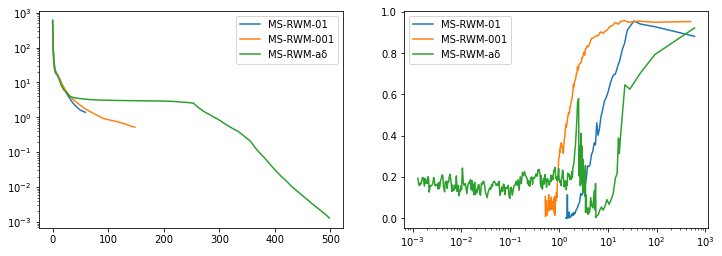

In [27]:
# Don't show from the smallest epsilons, or it will be too much
starting_index = 2

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

# Epsilon / Iteration
ax[0].plot(ms_rwm_01_05.εs[starting_index:], label='MS-RWM-01')
ax[0].plot(ms_rwm_001_05.εs[starting_index:], label='MS-RWM-001')
ax[0].plot(ms_rwm_aδ_05.εs[starting_index:], label='MS-RWM-aδ')
ax[0].plot(ms_hug_01_05.εs[starting_index:], label='MS-HUG-01')
ax[0].legend()
ax[0].set_yscale('log')

# Acceptance Probability / Epsilon
ax[1].plot(ms_rwm_01_05.εs[starting_index:], ms_rwm_01_05.PROP_MOVED[starting_index:], label='MS-RWM-01')
ax[1].plot(ms_rwm_001_05.εs[starting_index:], ms_rwm_001_05.PROP_MOVED[starting_index:], label='MS-RWM-001')
ax[1].plot(ms_rwm_aδ_05.εs[starting_index:], ms_rwm_aδ_05.PROP_MOVED[starting_index:], label='MS-RWM-aδ')
ax[1].plot(ms_hug_01_05.εs[starting_index:], ms_hug_01_05.PROP_MOVED[starting_index:], label='MS-HUG-01')
ax[1].legend()
ax[1].set_xscale('log')

plt.show()